# Machine Learning using Decision Trees

I know we meet every week to discuss this, but I thought I should write a notebook to explain what I have discovered so far about decision trees (at least so far as I understand them). For the `DecisionTreeRegressor` object in `scikit-learn`, there is also a plotting function called `plot_tree`. You can use this to get a visual representation of how the model determines the output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

We begin with a simple one-dimensional model. Note that the $x$ values must be a 2D array with shape $\left( n_{samples}, n_{features} \right)$ to mimic a table. You can uncomment the end of the $y$ definition if you want to test the effect of noise.

$$
f(x) = \frac{1}{x^2}
$$

In our case, we want a `numpy` array of shape $ \left( 20, 1 \right) $, since $ n_{samples}=20 $ and $ n_{features}=1 $.

In [2]:
N = 4
n = 100

x1 = np.sort(np.random.rand(N), axis=0)
x = np.sort(np.random.rand(N, 1), axis=0)
y = 1/x.mean(1)**2 #+ np.random.normal(size=(10))

In [3]:
x1

array([0.14463602, 0.25139852, 0.29983224, 0.65919215])

In [4]:
x

array([[0.22160333],
       [0.40817011],
       [0.59247295],
       [0.69711962]])

## Decision Tree

You already know that this is the simplest method. One decision tree divides the code into a series of boolean statements. This is what you can view using `plot_tree`. The majority of the use-cases for this will *overfit* the data, so the decision tree will try its best to exactly fit the training data. For the one-dimensional case, you can clearly see from the plot that the fit is step-wise. The error from the theoretical model is quite large in this case.

What `random_state` alters is how the algorithm chooses which features to fit first. In this very basic example with $1$ feature, changing the random seed does not alter the result.

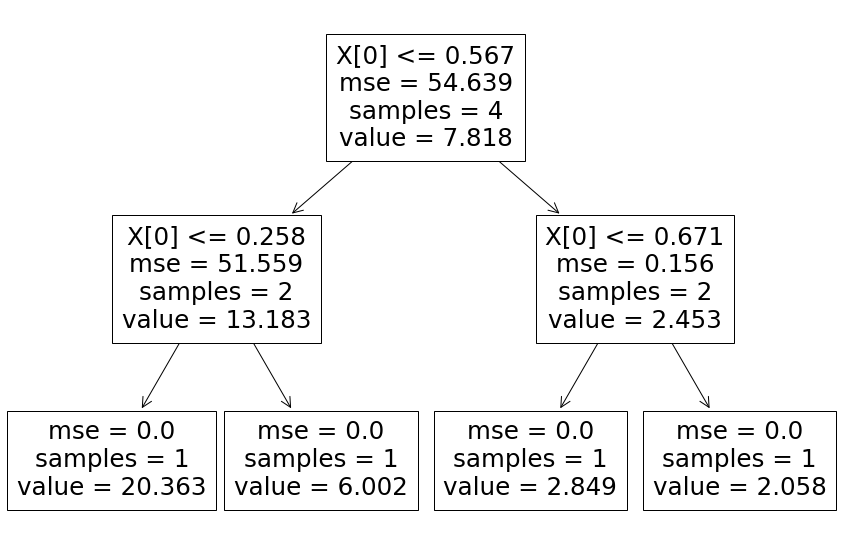

In [5]:
%matplotlib inline

tree_model = DecisionTreeRegressor(random_state=42, splitter='random')

tree_model.fit(x, y)

fig,ax = plt.subplots(1, 1, figsize=(15, 10))
plot_tree(tree_model, ax=ax)

x_new = np.sort(np.random.rand(n, 1), axis=0)*(x.max()-x.min())+x.min()
y_new =  1/x_new**2
y_model = tree_model.predict(x_new)

53.01600075504328

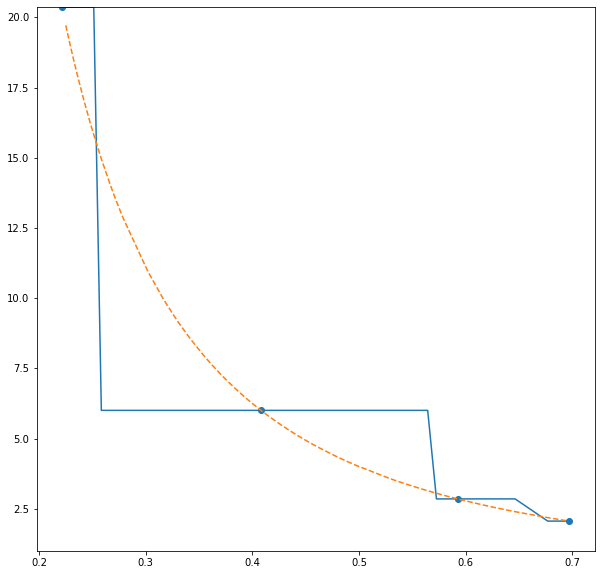

In [6]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(x.shape[1]):
    ax.scatter(x[:, i], y)
ax.plot(x_new, y_model)
ax.plot(x_new, y_new, ls='--')
ax.set_ylim([1, y.max()])
(y_model-y_new).var()

## Random Forest

The random forest will create many decision trees, and each tree is fitted with a sample of the training data with replacement (ie. a bootstrap sample; this can be turned off by setting `bootstrap`=**False**). While an individual decision tree might overfit the data, a random forest attempts to cancel-out these errors by averaging over all of the trees. There is still a possibility for this overfit, but in general it has smaller variance than a single tree.

In [7]:
forest_model = RandomForestRegressor(random_state=0)

forest_model.fit(x, y)

x_new = np.sort(np.random.rand(n, 1), axis=0)*(x.max()-x.min())+x.min()
y_new =  1/x_new**2
y_model = forest_model.predict(x_new)

36.493098628593906

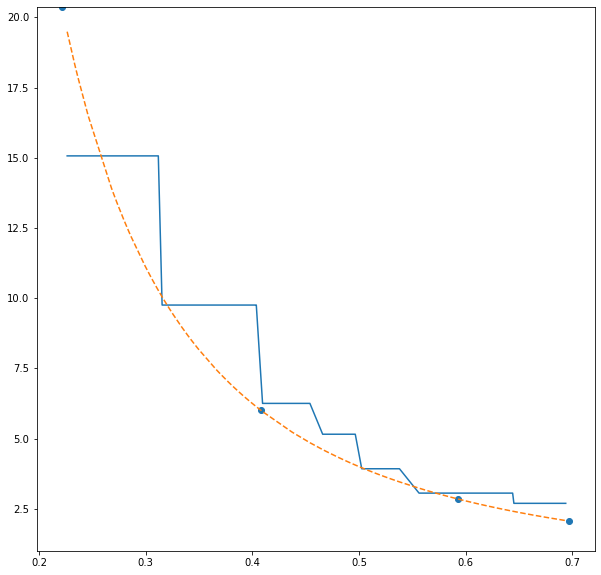

In [8]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(x.shape[1]):
    ax.scatter(x[:, i], y)
ax.plot(x_new, y_model)
ax.plot(x_new, y_new, ls='--')
ax.set_ylim([1, y.max()])
(y_model-y_new).var()

## Extremely-randomised Trees

`ExtraTrees` inject further randomness by choosing the node splitting at random, then selecting the one that gives the best fit. There is a bootstrap kwarg that is **False** by default, so the entire training data is used to fit each tree. This might contradict some explanation you find online (I know [this](https://stats.stackexchange.com/questions/175523/difference-between-random-forest-and-extremely-randomized-trees) thread on stats.stackexchange, for example) which claimed `ExtraTrees` samples without replacement. This has the lowest variance and as far as I read it has the best performance when there is noise, but `scikit-learn` also warn that it has greater bias (overfitting).

In [9]:
extratrees_model = ExtraTreesRegressor(random_state=None)

extratrees_model.fit(x, y)

x_new = np.sort(np.random.rand(n, 1), axis=0)*(x.max()-x.min())+x.min()
y_new =  1/x_new**2
y_model = extratrees_model.predict(x_new)

47.63735868558667

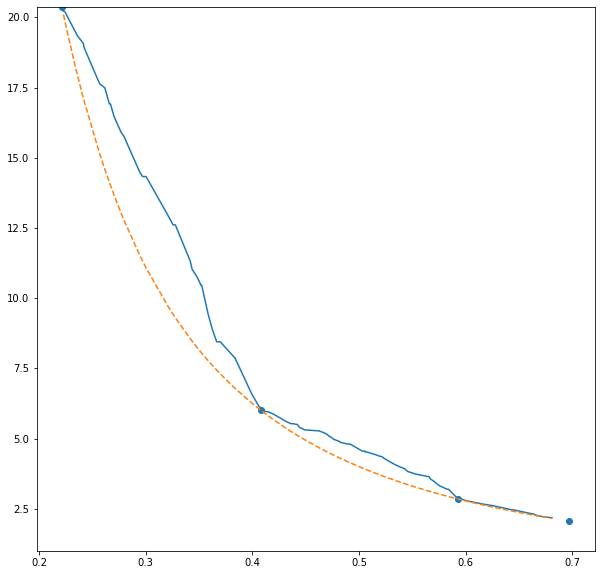

In [10]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(x.shape[1]):
    ax.scatter(x[:, i], y)
ax.plot(x_new, y_model)
ax.plot(x_new, y_new, ls='--')
ax.set_ylim([1, y.max()])
(y_model-y_new).var()

## Keyword Arguments

Not all of these classes share the same kwargs, but there are a few similarities.

 - `random_state`: so far as I can tell, this sets the seed for the randomness of each instance. In this one-dinensional example, the `DecisionTreeRegressor` class is unaffected by it, but the effect can be seen in the `RandomForestRegressor` and `ExtraTreesRegressor` classes.
 - `max_depth`: this defines the maximum number of splitting nodes before getting to a leaf. You can try it with the decision tree example to see its effect. 
 - `min_samples_split`: by default this is $2$. A node with fewer traning data points becomes a leaf.
 - `min_samples_leaf`: by default this is $1$, so each training data point can exist in its own leaf. 
 - `max_features`: you can set the maximum number of features to fit in a tree. These features may differ between trees for the ensemble models.
 - `max_leaf_nodes`: I think this is covered in the introduction notebook. Limiting the number of leaf nodes will prevent overfitting the data.
 - `bootstrap`: **True** by default for `RandomForestRegressor` and **False** for `ExtraTreesRegressor`. Activating this willl draw samples with replacement to train the trees in the ensemble.
 - `n_jobs`: you can set this to activate multithreading for handling the ensemble methods. In this case job will work on one tree.
 - `max_samples`: this is used if `bootstrap`=**True**. It sets the maximum size of the samples if it is of type *int*. It may alternatively be set as a *float* $\in (0, 1)$ to sample a fraction of the training data.

## Multi-dimensional Input

In my view, decision trees offer a solution to interpolating in $\mathcal{N}$ dimensions. In my experience, there are two solutions for this using `scipy`: `LinearNDInterpolator` and `Rbf`. The former assumes a linear model to interpoplate between two points, while the latter (radial basis function) can be quite computationally expensive while not offering much more in terms of performance. Decision trees, conversely, do not assume some pre-existing model to interpolate between the training data. Utilising forests or extremely-randomised trees thus give a non-parametric solution for data that does not easily fit some theoretical model.

In [36]:
from scipy.interpolate import LinearNDInterpolator
from mpl_toolkits.mplot3d import Axes3D

In [65]:
N = 1000
N_new = 1000

# Define the initial training data
v = np.random.normal(size=(3, N))
vn = v / np.sqrt(np.sum(v**2, axis=0))
vv = vn[2]*(vn[0]+vn[1])**2
phi = np.arctan2(vn[1], vn[0])
theta = np.arctan2(vn[2], np.sqrt(vn[0]**2+vn[1]**2))
vnn = np.stack([phi, theta], axis=0)

# Set the new data point which we will fit (or interpolate) to the model
v_new = np.random.normal(size=(3, N_new))
vn_new = v_new / np.sqrt(np.sum(v_new**2, axis=0))# / 2
vv_new = vn_new[2]*(vn_new[0]+vn_new[1])**2
phi_new = np.arctan2(vn_new[1], vn_new[0])
theta_new = np.arctan2(vn_new[2], np.sqrt(vn_new[0]**2+vn_new[1]**2))
vnn_new = np.stack([phi_new, theta_new], axis=0)

### Linear Interpolation

The issue here is that all of the data is confined to a unit sphere, so it is better to define the input data in terms of the polar and azimuth angles.

In [66]:
# sphere_interpolator = LinearNDInterpolator(vn.T, vv, fill_value=0)
sphere_interpolator = LinearNDInterpolator(vnn.T, vv, fill_value=0)

# vv_model = sphere_interpolator(vn_new.T)
vv_model = sphere_interpolator(vnn_new.T)

In [67]:
(vv_model-vv_new).var()

0.0010202276833727929

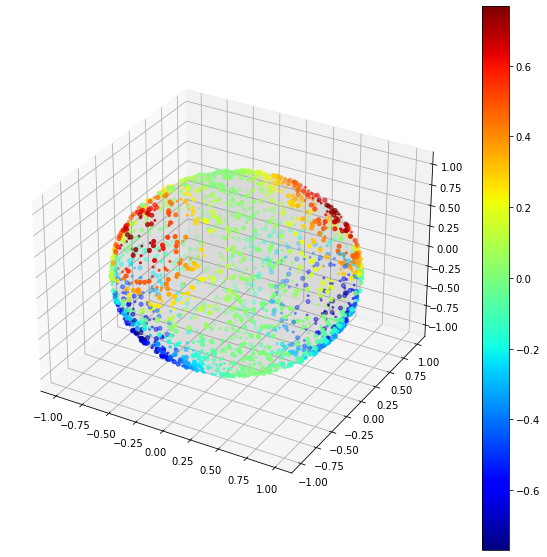

In [68]:
# Plot the training data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
cm = ax.scatter(vn[0], vn[1], vn[2], c=vv, cmap='jet', s=4)
cb = fig.colorbar(cm)

# Plot the interpolated points
ax.scatter(vn_new[0], vn_new[1], vn_new[2], c=vv_model, cmap='jet', s=16)

# Plot the surface of the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='k', linewidth=0, alpha=0.05)

### Extremely-randomised trees

The advantage of `ExtraTreesRegressor` is that we do not need to convert the input to polar and azimuth angles. This is done anyways to have a more-direct comparison with the linear interpolation example. As you can see from the following cells, the variance in this method for interpolation is lower by a factor of $2$. In succesive runs, this method may sometimes have higher variance. It depends on the random data we want to fit.

In [69]:
sphere_extratrees = ExtraTreesRegressor(random_state=0)
# sphere_extratrees.fit(vn.T, vv)
sphere_extratrees.fit(vnn.T, vv)

# vv_model = sphere_extratrees.predict(vn_new.T)
vv_model = sphere_extratrees.predict(vnn_new.T)

In [70]:
(vv_model-vv_new).var()

0.0004567039783770737

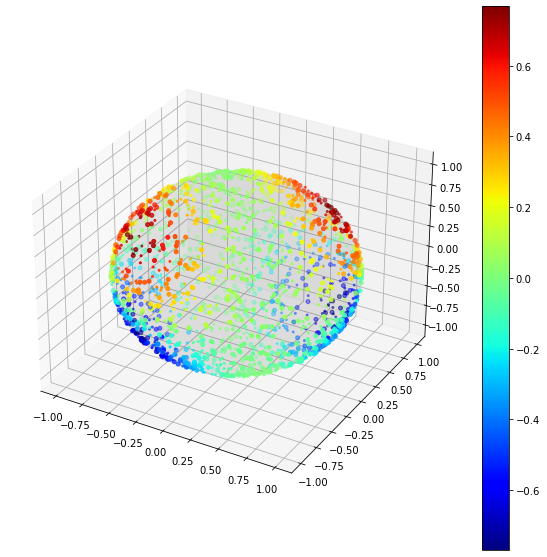

In [71]:
# Plot the traning data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
cm = ax.scatter(vn[0], vn[1], vn[2], c=vv, cmap='jet', s=4)
cb = fig.colorbar(cm)

# Plot the fitted points
ax.scatter(vn_new[0], vn_new[1], vn_new[2], c=vv_model, cmap='jet', s=16)

# Plot the surface of the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='k', linewidth=0, alpha=0.05)

### Final Remarks

The performance of supervised machine learning for this example of $\mathcal{N}$-dimensional interpolation was only slightly better than the standard methods. This is not in general a proof that this is always the case. This is a simple test case of an analytic model in $3$ dimensions which happened to be adequately interpolated with a linear method. It is of course possible that machine learning would be much more accurate in higher dimensions and in cases where the input data do not follow an analytic model. In my view, that is the true power of this approach.

It is also worth noting that `LinearNDInterpolator` cannot extrapolate points (you can only use imputation: fill a default value) while the machine-learning approach seems to fill in the nearest value. This is the reason one cannot interpolate the Cartesian points of the surface of the sphere, but fitting an ensemble is fine. We can test this hypothesis by trying to interpolate points *inside* the sphere. In this case, the variance of the interpolated points should be higher than the variance of the fitted points.